In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy
from collections import namedtuple
import numpy as np
import cupy as cp
import math
import json

%run kernel.ipynb

4.93 μs ± 103 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.04 μs ± 68.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [2]:
config = Config()

In [3]:
%%time
IMAGES = []
IMAGES_BW = []
IMAGE_METADATA = []
metadata = {}

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        IMAGE_METADATA.append(dict(file_name=image_fname, **metadata_record))
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGE_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_BW = (IMAGES / 255).astype(np.uint8)
IMAGES_BW_ONES = IMAGES_BW @ np.ones(IMAGES_BW.shape[1]).T
assert np.array_equal(IMAGES_BW_ONES[:10], (IMAGES_BW[:10] == 1).sum(axis=-1))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/9202 [00:00<?, ?it/s]

Loaded 9201 images
CPU times: user 487 ms, sys: 71.9 ms, total: 558 ms
Wall time: 502 ms


In [4]:
BASE_KERNEL_SIZE = 32
BAR_WIDTH = 4  # relative to BASE_KERNEL_SIZE. I.e. for 32 BAR_WIDTH would be 4/32, for 16 - 4/16, etc.
MAX_STRECH_FACTOR = 4
OFFSET_X_LEVELS = 17
OFFSET_Y_LEVELS = 17
STRETCH_X_LEVELS = 1
STRETCH_Y_LEVELS = 1
ROTATION_LEVELS = 24

assert STRETCH_X_LEVELS > 0 
assert STRETCH_Y_LEVELS > 0 
assert ROTATION_LEVELS > 0
assert OFFSET_X_LEVELS > 0 and OFFSET_X_LEVELS % 2
assert OFFSET_Y_LEVELS > 0 and OFFSET_Y_LEVELS % 2

In [5]:
offset_x_transfs = []
offset_y_transfs = []
stretch_x_transfs = []
stretch_y_transfs = []
rotation_transfs = []
identity_transf = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# cover possible offsets from edge of an object to nearest edge of bounds
offset_x_transfs.append(identity_transf)

for i in range(OFFSET_X_LEVELS // 2):
    l = 0.5 / ((OFFSET_X_LEVELS - 1) // 2) * (i + 1)
    r = -l
    transf = [
        [1, 0, l],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))
    transf = [
        [1, 0, r],
        [0, 1, 0],
        [0, 0, 1]
    ]
    offset_x_transfs.append(np.array(transf))

# cover possible offsets from edge of an object to nearest edge of bounds
offset_y_transfs.append(identity_transf)

for i in range(OFFSET_Y_LEVELS // 2):
    u = 1 / ((OFFSET_Y_LEVELS - 1) // 2) * (i + 1)
    d = -u
    transf = [
        [1, 0, 0],
        [0, 1, u],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))
    transf = [
        [1, 0, 0],
        [0, 1, d],
        [0, 0, 1]
    ]
    offset_y_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_X_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_X_LEVELS - 1)) + 1 if STRETCH_X_LEVELS > 1 else 1
    transf = [
        [f, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
    stretch_x_transfs.append(np.array(transf))

# cover possible STRETCHES from 1x to MAX_STRETCH_FACTOR
for i in range(STRETCH_Y_LEVELS):
    f = i * ((MAX_STRETCH_FACTOR - 1) / (STRETCH_Y_LEVELS - 1)) + 1 if STRETCH_Y_LEVELS > 1 else 1
    transf = [
        [1, 0, 0],
        [0, f, 0],
        [0, 0, 1]
    ]
    stretch_y_transfs.append(np.array(transf))

# cover possible rotations counter clock wise (0 - is no rotation)
for i in range(ROTATION_LEVELS):
    theta = (2 * math.pi / ROTATION_LEVELS) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

In [6]:
TRANSFS = []
break_on_transf = -1
i = 0

for a in stretch_x_transfs:
    for b in stretch_y_transfs:
        for c in rotation_transfs:
            for d in offset_x_transfs:
                for e in offset_y_transfs:
                    if break_on_transf > 0 and i == break_on_transf:
                         assert False
                    # https://learn.microsoft.com/en-us/dotnet/desktop/winforms/advanced/why-transformation-order-is-significant?view=netframeworkdesktop-4.8
                    # We need first scale, then rotate (around origin), then translate
                    transf = e @ d @ c @ b @ a
                    TRANSFS.append(transf)
                    i += 1

print(f'{len(TRANSFS)} transformations')

6936 transformations


In [7]:
def draw_kernel_bar(p1, p2, p3, p4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.polygon([tuple(p1), tuple(p2), tuple(p3), tuple(p4)], fill=255, outline=255, width=1)
    return image

In [8]:
def draw_kernel_arc(p1, p2, start_angle=0, end_angle=360/4, size=32):
    image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(image)
    draw.arc([tuple(p1), tuple(p2)], start=start_angle, end=end_angle, fill=255, width=4)
    return image

In [9]:
def get_kernel_size(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return size
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel.shape[0]

In [10]:
def get_kernel_shape(kernel):
    sz = get_kernel_size(kernel)
    return (sz, sz)

In [11]:
def kernel_as_matrix(kernel):
    if len(kernel.shape) == 1: # Raveled array
        size = int(math.sqrt(kernel.shape[0]))
        assert size * size == kernel.shape[0]
        return kernel.reshape(size, size).astype(np.uint8)
        
    assert len(kernel.shape) == 2
    assert kernel.shape[0] == kernel.shape[1]
    assert kernel.dtype == np.uint8
    return kernel

In [12]:
def kernel_as_image(kernel):
    data = (kernel * 255).astype(np.uint8)
    return Image.frombytes('L', size=get_kernel_shape(kernel), data=data)

In [13]:
def display_kernel_raw(kernel):
    kernel = kernel_as_matrix(kernel)
    
    for r in kernel:
        s = ''
        for c in r:
            s += ' ' + str(c)

        print(s)            

In [14]:
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
szsz = 32
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
#transf = offset_y_transfs[1]  @ rotation_transfs[3] @ stretch_x_transfs[4]
#transf = stretch_x_transfs[4]
# transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_bar).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_bar(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    (points_x[2], points_y[2]),
    (points_x[3], points_y[3]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel)

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [15]:
l = '0 0 0 0 0 0 0 0 0 0 0 0 0 0'
r = '0 0 0 0 0 0 0 0 0 0 0 0 0 0'
(np.asmatrix(l) == 0).sum(), (np.asmatrix(r) == 0).sum(), 

(np.int64(14), np.int64(14))

In [16]:
prototype_points_arc = [
    [0 - 0.25,  0 + 0.25],
    [0 + 0.25,  0 - 0.25],
    [1,        1,       ]
]
szsz = 32
center_pt = szsz / 2
#transf = e @ d @ c @ b @ a
#transf = offset_y_transfs[1]  @ rotation_transfs[3] @ stretch_x_transfs[4]
#transf = stretch_x_transfs[4]
#transf = offset_x_transfs[1]
# transf = stretch_x_transfs[6]
#transf = stretch_x_transfs[3]
# transf = stretch_y_transfs[5]
# transf = offset_y_transfs[5] @ stretch_y_transfs[5]
transf = identity_transf
points = (transf @ prototype_points_arc).T
# points_x = np.round(points[:,0] * szsz + center_pt).astype(np.int32)
# points_y = np.round(points[:,1] * -szsz + center_pt).astype(np.int32)
points_x = (points[:,0] * szsz + center_pt).astype(np.int32)
points_y = (points[:,1] * -szsz + center_pt).astype(np.int32)
kernel_image = draw_kernel_arc(
    (points_x[0], points_y[0]),
    (points_x[1], points_y[1]),
    size=szsz)
kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
#kernel_as_image(kernel).resize((320, 320))
display_kernel_raw(kernel)

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [17]:
%%time
config.reload()
KERNELS = []
KERNEL_PARAMS = []
KERNELS_AS_OBJ = []

# prototype is a simple vertical bar of half size of kernel
lw = 1 / BASE_KERNEL_SIZE # line width 
hlw = lw / 2 # half line width
hbw = BAR_WIDTH * lw / 2 # half bar width
prototype_points_bar = np.array([
    [-hbw      , +0.25      , 1],
    [-hbw      , -0.25 + hlw, 1],
    [+hbw - hlw, -0.25 + hlw, 1],
    [+hbw - hlw, +0.25      , 1],
]).T
noncomplex_kernels_count = 0
center_pt = config.kernel_size / 2
transfs = TRANSFS
transfs = []

for transf in tqdm(transfs, desc='bar'):
    points = (transf @ prototype_points_bar).T
    points_x = (points[:,0] * config.kernel_size + center_pt).astype(np.int32)
    points_y = (points[:,1] * -config.kernel_size + center_pt).astype(np.int32)
    kernel_image = draw_kernel_bar(
        (points_x[0], points_y[0]),
        (points_x[1], points_y[1]),
        (points_x[2], points_y[2]),
        (points_x[3], points_y[3]),
        size=config.kernel_size)
    kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
    ones_count = (kernel == 1).sum()
    complexity = ones_count / len(kernel)

    if complexity <= config.kernel_min_complexity: 
        noncomplex_kernels_count += 1
        continue
    
    denominator = 255 * ones_count
    KERNELS.append(kernel)
    KERNEL_PARAMS.append([ones_count, denominator])

    kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
    assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
    KERNELS_AS_OBJ.append(kernel_as_obj)

arcs_per_360 = 8

for xcenter in tqdm(range(0, config.kernel_size, 2), 'arc'):
    for ycenter in range(0, config.kernel_size, 2):
        for angle in range(0, 360, 360//arcs_per_360):
            kernel_image = draw_kernel_arc(
                (xcenter - center_pt, ycenter - center_pt),
                (xcenter + center_pt, ycenter + center_pt),
                start_angle=angle,
                end_angle=angle + 360/arcs_per_360,
                size=config.kernel_size)
            kernel = (np.array(kernel_image) / 255).astype(np.uint8).ravel()
            ones_count = (kernel == 1).sum()
            complexity = ones_count / len(kernel)
        
            if complexity <= config.kernel_min_complexity: 
                noncomplex_kernels_count += 1
                continue
            
            denominator = 255 * ones_count
            KERNELS.append(kernel)
            KERNEL_PARAMS.append([ones_count, denominator])
        
            kernel_as_obj = Kernel.from_m_data_nog((np.array(kernel_image) / 255).astype(np.uint8))
            assert kernel_as_obj.m_ones[0] == ones_count, (kernel_as_obj.m_ones[0], ones_count)
            KERNELS_AS_OBJ.append(kernel_as_obj)

KERNELS = np.array(KERNELS)
KERNEL_PARAMS = np.array(KERNEL_PARAMS)
KERNELS_AS_OBJ = np.array(KERNELS_AS_OBJ)
assert len(KERNELS) == len(KERNEL_PARAMS)
assert len(KERNELS) == len(KERNELS_AS_OBJ)

print(f'{len(KERNELS)} kernels generated, {noncomplex_kernels_count} noncomplex omitted')

bar: 0it [00:00, ?it/s]

arc:   0%|          | 0/16 [00:00<?, ?it/s]

1170 kernels generated, 878 noncomplex omitted
CPU times: user 847 ms, sys: 6.91 ms, total: 854 ms
Wall time: 849 ms


In [18]:
%%time
# Deduplication
kernels_cross = np.matmul(KERNELS, KERNELS.T, dtype=np.int32)
kernels_cross_norm = kernels_cross / KERNEL_PARAMS[:,0]
kernels_cross_norm_sum = kernels_cross_norm + kernels_cross_norm.T # 100% dups will give 1+1=2, 99% dups will give 0.99+0.99=1.98

CPU times: user 1.11 s, sys: 9 ms, total: 1.12 s
Wall time: 1.12 s


In [19]:
# Verify cross score calculation
for _ in range(100):
    i = np.random.randint(kernels_cross.shape[0])
    j = np.random.randint(kernels_cross.shape[1])
    ones_j = KERNEL_PARAMS[j,0]
    #print(f'{i}\t{j}\t{kernels_cross[i,j]}\t{kernels_cross_norm[i,j]:.2f}\t{ones_j}')
    cross_norm = kernels_cross[i,j] / ones_j if ones_j > 0 else 0
    assert np.isclose(cross_norm, kernels_cross_norm[i,j]), (cross_norm, kernels_cross_norm[i,j])

In [20]:
%%time
KERNEL_DUPS_THRESHOLD=0.99
kernel_dups = []
kernels_for_remove = set()

for i, i_row in enumerate(kernels_cross_norm_sum):
    for j, s in enumerate(i_row):
        if j >= i: # either diagonal or upper right part of matrix encountered
            break

        if s >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD): # treat 99% two-side intersection as redundant
            kernel_dups.append((i, j))
            kernels_for_remove.add(j)

total_kernel_for_remove = len(kernels_for_remove)
total_kernels = len(KERNELS)
print(f'Found {total_kernel_for_remove} of {total_kernels} ({(total_kernel_for_remove / total_kernels) * 100:.2f}%) duplicate kernels for {KERNEL_DUPS_THRESHOLD} threshold') 

Found 0 of 1170 (0.00%) duplicate kernels for 0.99 threshold
CPU times: user 65.1 ms, sys: 33 μs, total: 65.1 ms
Wall time: 64.3 ms


In [21]:
# Verify dups calculation against POJO Kernels
kernel_dups_indicies = np.random.randint(len(kernel_dups), size=100) if kernel_dups else []

for i in kernel_dups_indicies:
    dup_entry = kernel_dups[i]
    kernel1 = KERNELS_AS_OBJ[dup_entry[0]]
    kernel2 = KERNELS_AS_OBJ[dup_entry[1]]
    is_match1to2, match_score1to2 = kernel1.match(kernel2.m * 255, 0.01)
    is_match2to1, match_score2to1 = kernel2.match(kernel1.m * 255, 0.01)
    assert is_match1to2 == True
    assert is_match2to1 == True
    assert (match_score1to2 + match_score2to1) >= (KERNEL_DUPS_THRESHOLD + KERNEL_DUPS_THRESHOLD), (dup_entry, match_score1to2, match_score2to1)

In [22]:
KERNELS = np.delete(KERNELS, list(kernels_for_remove), axis=0)
KERNEL_PARAMS= np.delete(KERNEL_PARAMS, list(kernels_for_remove), axis=0)
KERNELS_AS_OBJ= np.delete(KERNELS_AS_OBJ, list(kernels_for_remove), axis=0)
print(f'{len(KERNELS)} unique kernels retained, {len(kernels_for_remove)} dropped')

1170 unique kernels retained, 0 dropped



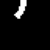
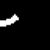
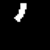
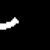
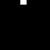
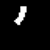
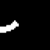
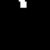
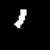
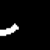
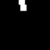
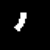
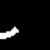
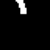
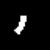
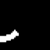
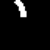
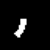
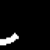
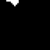
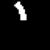
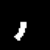
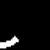
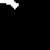
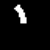
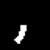
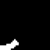
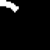
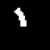
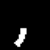
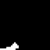
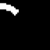
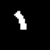
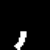
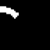
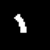
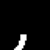
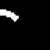
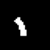
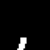
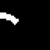
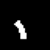
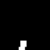
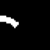
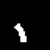
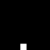
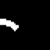
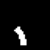
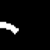
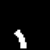
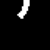
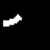
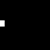
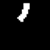
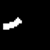
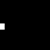
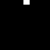
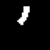
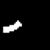
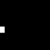
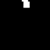
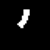
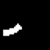
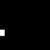
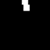
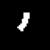
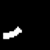
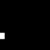
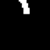
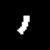
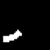
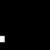
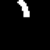
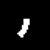
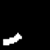
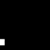
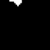
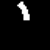
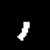
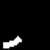
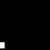
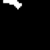
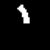
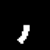
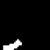
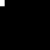
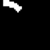
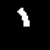
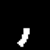
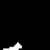
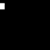
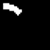
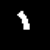
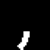
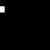
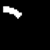
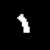
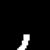
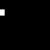
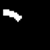
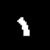
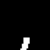
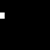
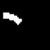
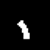
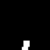
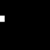
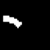
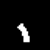
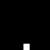
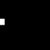
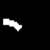
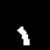
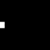
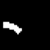
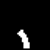
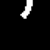
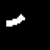
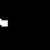
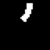
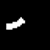
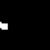
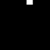
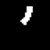
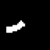
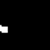
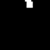
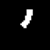
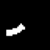
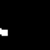
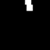
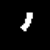
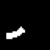
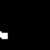
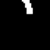
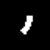
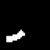
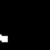
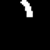
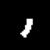
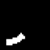
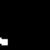
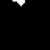
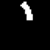
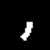
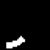
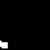
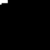
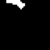
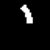
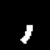
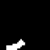
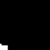
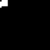
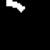
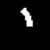
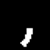
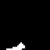
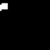
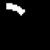
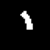
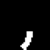
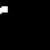
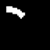
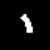
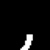
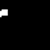
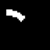
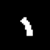
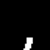
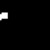
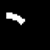
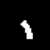
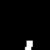
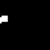
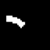
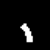
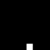
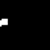
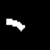
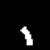
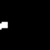
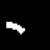
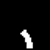
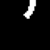
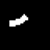
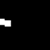
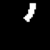
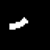
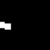
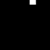
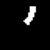
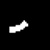
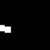
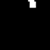
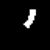
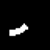
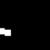
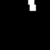
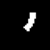
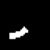
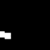
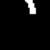
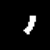
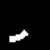
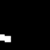
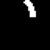
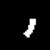
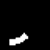
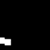
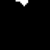
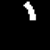
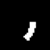
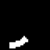
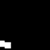
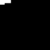
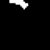
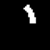
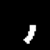
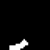
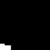
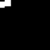
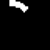
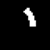
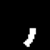
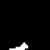
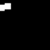
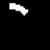
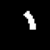
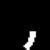
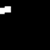
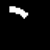
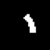
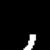
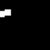
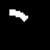
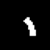
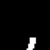
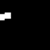
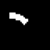
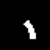
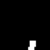
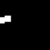
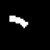
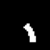
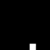
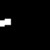
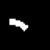
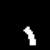
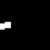
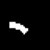
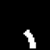
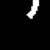
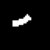
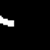
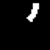

In [23]:
max_to_show = 256

if max_to_show > 0:
    kernel_images = np.copy(KERNELS[:max_to_show])
    kernel_image_denoms = KERNEL_PARAMS[:max_to_show,1]
else:
    kernel_images = np.copy(KERNELS)
    kernel_image_denoms = KERNEL_PARAMS[:,1]

# Turn to column vector
assert kernel_image_denoms.shape == (max_to_show,)
kernel_image_denoms = kernel_image_denoms.reshape(1,-1).T
assert kernel_image_denoms.shape == (max_to_show, 1)
kernel_images *= 255 # turn to 0..255

_images = []
_captions = dict()

for i in range(kernel_images.shape[0]):
    _image = Image.frombytes('L', size=get_kernel_shape(kernel_images[i]), data=kernel_images[i].astype(np.uint8))
    _image = _image.resize((50, 50))
    _images.append(_image)
    _captions[id(_image)] = i
    
display_images_grid(_images, 16, captions=_captions)

In [24]:
%%time

kernel_denoms = KERNEL_PARAMS[:,1]
kernel_denoms = kernel_denoms.reshape(1,-1).T # turn to column vector (many rows, single column)
KERNELS_SCALED = KERNELS / kernel_denoms 
MATCH_MATRIX_COVERAGE = np.matmul(IMAGES, KERNELS.T, dtype=np.int32) # match matrix which favors kernels which cover more points of an image
MATCH_MATRIX_PRECISION = IMAGES @ KERNELS_SCALED.T # match matrix which favors kernels which cover points of an image with less error (excess)

CPU times: user 8.52 s, sys: 453 ms, total: 8.97 s
Wall time: 7.11 s


In [25]:
np.unique(IMAGES[0])

array([  0, 255], dtype=uint8)

In [26]:
# verify correctness vs Kernel POJO
image_random_indices = np.random.randint(len(IMAGES), size=(100,))
kernel_random_indices = np.random.randint(len(KERNELS), size=(100,))

for i in image_random_indices:
    for j in kernel_random_indices:
        match_score1 = MATCH_MATRIX_PRECISION[i,j]
        image = IMAGES[i].reshape(config.kernel_size, config.kernel_size)
        kernel = KERNELS_AS_OBJ[j]
        assert np.array_equal(kernel.m, KERNELS[j].reshape(config.kernel_size, config.kernel_size))
        match_score2 = kernel.match(image, 0.01)[1]
        assert np.isclose(match_score1, match_score2), (i, j, match_score1, match_score2)

In [27]:
class Memory:
    def __init__(self):
        self.impressions = np.array([], dtype=np.uint8).reshape(0, 1024)
        self.impressions_params = np.delete(self.create_params(0, 0, 0), 0).view(np.recarray) # create empty rec array via delete =)
        #self.values = np.rec.array([], dtype=[('impression_index', 'i4'), ('value', 'object'), ('counter', 'i4')])

    def add_impression(self, impression):
        self.impressions = np.append(self.impressions, [impression], axis=0) 
        ones = (impression == 1).sum()
        hits = 1
        ttl = 100 + np.exp(hits)
        params = self.create_params(ones, hits, ttl)
        self.impressions_params = np.append(self.impressions_params, params).view(np.recarray)

    def touch_impression(self, impression_index):
        hits = self.impressions_params.hits[impression_index]
        self.impressions_params.hits[impression_index] = hits + 1
        ttl_add = np.exp(hits + 1) - np.exp(hits) if hits < 50 else np.inf
        self.impressions_params.ttl[impression_index] += ttl_add

    def create_params(self, ones, hits, ttl):
        return np.rec.array([(ones, hits, ttl)], dtype=[('ones', 'i4'), ('hits', 'i4'), ('ttl', 'f4')])

    def remove_stale_impressions(self):
        indices = np.argwhere(self.impressions_params.ttl <= 0)
        self.impressions = np.delete(self.impressions, indices, axis=0)
        self.impressions_params = np.delete(self.impressions_params, indices, axis=0).view(np.recarray)
        assert self.impressions.shape[0] == self.impressions_params.shape[0]

In [36]:
MEMORY = Memory()

image_indices = np.arange(0, len(IMAGES))
image_indices = np.arange(0, 500)

match_matrix = MATCH_MATRIX_PRECISION
kernels_max_count=50
assert match_matrix.shape[0] == IMAGES.shape[0]
match_matrix_kernel_indices_sorted_desc = np.argsort(-match_matrix, axis=-1)

trials = 10

for _ in tqdm(range(trials)):
    image_indices = np.random.randint(len(IMAGES), size=1000)
    
    for image_index in tqdm(image_indices):
        image_bw = IMAGES_BW[image_index]
        image_bw_ones = IMAGES_BW_ONES[image_index]
        kernel_indices_sorted_desc = match_matrix_kernel_indices_sorted_desc[image_index]
    
        if image_bw_ones == 0:
            # TODO handle somehow?
            print(f'Image #{image_index} is empty!')
            continue
    
        kernels_composed_indices = []
        kernels_composed = None
        kernels_composed_coverage = None
        kernels_composed_excess = None
        kernels_composed_error = None
    
        for kernel_index in kernel_indices_sorted_desc:
            kernel = KERNELS[kernel_index]
            possible_kernels_composed = None
            image_to_kernels_composed_match = None
            
            # is it worth to add kernel to composition?
            if kernels_composed_indices:
                assert not kernels_composed is None
                possible_kernels_composed = np.logical_or(kernels_composed, kernel)
                image_to_kernels_composed_match = (image_bw.astype(np.uint32) @ possible_kernels_composed.T)
                possible_coverage = image_to_kernels_composed_match / image_bw_ones
    
                if not (possible_coverage > kernels_composed_coverage):
                    continue # this kernel adds nothing to composition => ignore
        
            kernels_composed_indices.append(kernel_index)
    
            if not possible_kernels_composed is None:
                kernels_composed = possible_kernels_composed
            else:
                kernels_composed = np.logical_or(kernels_composed, kernel) if not kernels_composed is None else kernel
                
            kernels_composed_ones = (kernels_composed == 1).sum()
            assert kernels_composed_ones > 0
    
            if image_to_kernels_composed_match is None:
                image_to_kernels_composed_match = image_bw.astype(np.uint32) @ kernels_composed.T
                
            uncovered_image_on_pixels = image_bw_ones - image_to_kernels_composed_match
            assert uncovered_image_on_pixels >= 0
            kernels_composed_coverage = image_to_kernels_composed_match / image_bw_ones
            kernels_composed_redundant_on_pixels = kernels_composed_on_pixels_count - image_to_kernels_composed_match
            kernels_composed_excess = kernels_composed_redundant_on_pixels / image_bw_ones
            kernels_composed_error = (kernels_composed_redundant_on_pixels + uncovered_image_on_pixels) / image_bw_ones
    
            if kernels_composed_coverage >= 1.0 or len(kernels_composed_indices) > kernels_max_count:
                break
    
        impression = kernels_composed
        impression_ones = kernels_composed_on_pixels_count
        memory_match = impression.astype(np.uint32) @ MEMORY.impressions.T
        memory_match_norm_a = memory_match / impression_ones
        memory_match_norm_b = memory_match / MEMORY.impressions_params.ones
        threshold = 0.8
        assert memory_match_norm_a.shape == memory_match_norm_b.shape
        recall_indices = np.argwhere((memory_match_norm_a > threshold) & (memory_match_norm_b > threshold))
        # recall_indices = np.arange(len(memory_match_norm_a))
        best_score_sum = 0
        best_recall_index = -1
        
        for recall_index in recall_indices:
            score_sum = memory_match_norm_a[recall_index] + memory_match_norm_b[recall_index]
    
            if score_sum > best_score_sum and score_sum >= (threshold * 2):
                best_score_sum = score_sum
                best_recall_index = recall_index
    
        if best_recall_index < 0:
            # no matching recall - create a new one
            MEMORY.add_impression(impression)
        else:
            MEMORY.touch_impression(best_recall_index)
    
        MEMORY.impressions_params.ttl -= 1

    MEMORY.remove_stale_impressions()

MEMORY.impressions.shape

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(100, 1024)


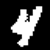
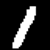
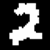
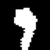
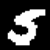
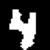
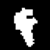
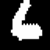
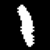
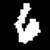
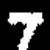
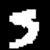
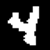
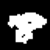
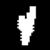
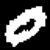
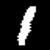
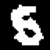
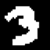
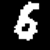
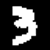
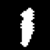
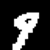
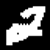
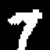
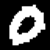
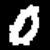
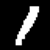
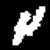
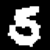
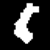
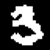
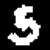
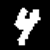
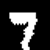
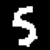
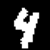
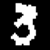
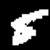
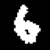
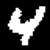
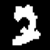
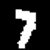
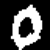
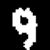
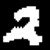
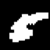
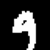
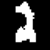
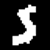
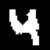
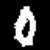
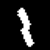
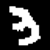
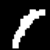
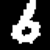
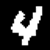
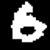
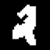
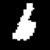
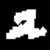
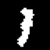
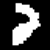
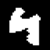
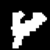
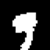
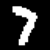
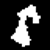
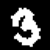
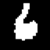
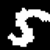
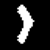
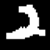
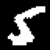
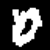
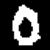
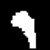
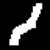
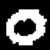
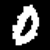
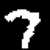
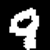
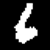
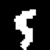
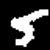
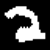
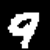
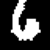
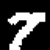
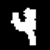
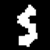
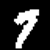
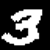
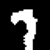
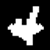
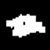
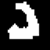
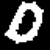
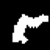
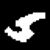

In [37]:
image_size_for_grid = (50, 50)
impression_images = []

for impression in MEMORY.impressions:
    impression_image = Image.frombytes('L', size=get_kernel_shape(impression), data=(impression * 255).astype(np.uint8))
    impression_image = impression_image.resize(image_size_for_grid)
    impression_images.append(impression_image)

display_images(impression_images)

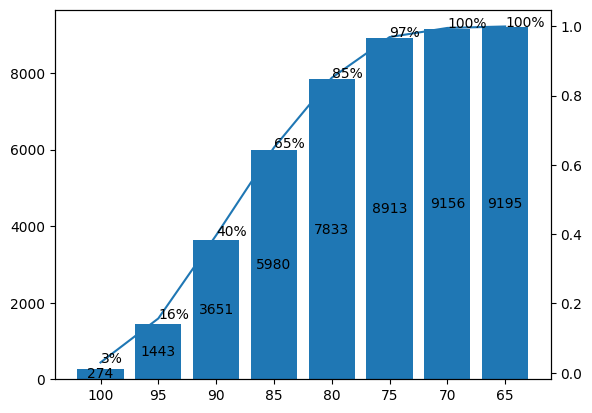

In [102]:
# теперь надо соотнести images и impressions из памяти - какая доля images метчиться???
memory_match1 = np.matmul(IMAGES_BW, MEMORY.impressions.T, dtype=np.int32)
memory_match2 = memory_match1 / IMAGES_BW_ONES.reshape(1,-1).T

levels = range(100, 60, -5)
absvalues = []
percvalues=[]

for level in levels:
    level = level / 100
    memory_match3 = (memory_match2 >= level) @ np.ones(memory_match2.shape[1]).T
    x = (memory_match3 > 0).sum()
    absvalues.append(x)
    percvalues.append(x / len(IMAGES_BW))

p = plt.bar(list(map(str, levels)), absvalues)
plt.bar_label(p, map(str, absvalues), label_type='center')

ax2 = plt.gca().twinx()
ax2.plot(list(map(str, levels)), percvalues)

for xy in zip(map(str, levels), percvalues):
    ax2.annotate(f'{xy[1]*100:.0f}%', xy=xy, textcoords='data')
    
plt.show()



In [80]:
list(levels), values

([100, 95, 90, 85, 80, 75, 70, 65],
 [np.int64(274),
  np.int64(1443),
  np.int64(3651),
  np.int64(5980),
  np.int64(7833),
  np.int64(8913),
  np.int64(9156),
  np.int64(9195)])

In [63]:
np.ones(memory_match.shape[1]).T.shape

(100,)

In [49]:
memory_match.shape

(9201, 100)

In [72]:
np.argwhere((memory_match2 >= 0.99))

TypeError: argwhere() got an unexpected keyword argument 'axis'

In [ ]:
from PIL import ImageFilter
image = Image.open(IMAGE_METADATA[0]['file_name'])
# for _ in range(10):
#     image = image.filter(ImageFilter.MinFilter(3))
# image = image.filter(ImageFilter.CONTOUR)
image = image.filter(ImageFilter.FIND_EDGES) #.filter(ImageFilter.MinFilter(1))
image.resize((200, 200))